Four-factor formula
=======================

In [350]:
from math import pi
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

mpl.style.use('seaborn')

N_a = 6.02E23 # atoms/mol

Fuel

In [351]:
fuel_rho = 11000  # kg/m3
fuel_mm = 0.270  # kg/mol

N_fuel = fuel_rho/fuel_mm*N_a  # atoms/m3

enrichment = 0.03

U235_xs_f = 580
U235_xs_c = 107
U235_xs_a = U235_xs_f + U235_xs_c
U235_nu = 2.43
U235_eta = U235_nu*U235_xs_f/U235_xs_a

U238_xs_c = 2.75

xs_a_fuel = (enrichment * U235_xs_a) + (1 - enrichment)*U238_xs_c

Moderator

In [352]:
water_rho = 1000
water_mm = 0.018

N_mod = water_rho/water_mm*N_a

# xs_s_mod = 99.52
xs_s_mod = 99.52
xs_a_mod = 0.5896

led_mod = 0.93
# led_mod = 0.4

Geometry

In [353]:
fuel_D = 0.01
V_m2f = 2/1

# This is to try and get geometrical variables later
# pin_pitch = 1.25984
# fuel = 0.39218
# pin = 0.45720

# fuel_area = (pi * fuel ** 2)
# pin_area = (pi * pin ** 2)
# mod_area = (pin_pitch ** 2) - pin_area

# fuel_D = 2*fuel /100
# V_m2f = mod_area/fuel_area

Fast fission $\epsilon$

This is the ratio of total fissions neutrons produced by the neutrons produced
just by thermal fission. So if only thermal fissions occur, $\epsilon = 1$, and
increases as the number of fissions happening at high energies increase.

Any neutron that does not cause a fission at high energies might survive to
cause fission at thermal energies.

In [354]:
eps = 1.024

Resonance Escape Probability p

The likelihood of the neutron avoiding capture in the fuel resonances by
losing energy through scattering in the moderator.

$ p = 1 - \frac{(1 - e)}{\frac{V_m}{V_f} \frac{N_m}{N_f} \xi_m \sigma_{s, m}}I $

Any neutron that did not cause fission at high energy and managed to lose
energy through scatter without being absorbed by the fuel resonances might
cause fission at thermal energies.

To-do:

This data comes from data used in homework at Cambridge University. It should
be revised to better represent a reactor, which most books indicate a practical
value of p $\approx$ 0.7. We are quite far from that.

Add a discussion on homogeneous vs heterogenous reactors and how heterogeneous
reactors have higher p due to self-shielding of the fuel.

In [355]:
def area_over_mass_rod(rho, D):
    """
    For a cylindrical rod, calculates the ratio of the surface area over its mass
    Ignores the circles on top and bottom.
    Valid for relatively long or thin rod.

    2 pi r H / rho pi r2 H = 2 / rho r = 4 / rho D
    """
    return 4/(rho*D)

def I_rod_300(mat, AoM):
    """
    Source:
     - Glasstone and Sesonske - Nuclear Reactor Engineering, Vol1 Reactor Design Basics, p.180
     - E.E. Lewis - Fundamentals of Nuclear Reactor Physics, p.105
     - Bell & Gasstone - Nuclear Reactor Theory, p.455

    AoM inside of the square root is in m2/kg.
    For AoM in cm2/g:
     - metal: a, b = 2.95, 25.8
     - oxide: a, b = 4.45, 26.6
    """
    coeff =  {'metal': (2.95, 81.5),
              'oxide': (4.45, 84.5)}

    if isinstance(mat, str):
        a, b = coeff[mat]
    else:
        a, b = mat

    return a + b*np.sqrt(AoM)

# We are trying to verify here against data given in Bell & Glasstone
expected_ver1 = 21.10
I_ver11 = I_rod_300((4.45, 26.6), 0.393)
print('Method 1, off by', I_ver11 - expected_ver1)
# This next method seems closed, so calculating A/M seems better
I_ver12 = I_rod_300((4.45, 26.6), area_over_mass_rod(10.2, 1.0))
print('Method 2, off by', I_ver12 - expected_ver1)
# If we use the values and coefficients in SI, it seems like all the conversion
# made it worse
I_ver13 = I_rod_300('oxide', area_over_mass_rod(10200, 0.01))
print('Method 3, off by', I_ver13 - expected_ver1)

expected_ver2 = 16.23
I_ver21 = I_rod_300('oxide', area_over_mass_rod(10200, 0.02))
print(I_ver21 - expected_ver2)

def I_T(I_300, T, beta=6E-3):
    """
    Correlation from both Glasstone books. Default beta from Glasstone and Sesonske.
    """
    return I_300*(1 + beta*(np.sqrt(T) - np.sqrt(300)))


def resonance_escape(enrichment, V_m2f, N_mod, N_fuel, led_mod, xs_s_mod, I):
    return 1 - (1 - enrichment)/((V_m2f) * (N_mod/N_fuel) * led_mod * xs_s_mod) * I

def resonance_escape2(enrichment, V_m2f, N_mod, N_fuel, led_mod, xs_s_mod, I):
    return np.exp( - (1 - enrichment)/((V_m2f) * (N_mod/N_fuel) * led_mod * xs_s_mod) * I)

I = I_rod_300('oxide',  area_over_mass_rod(fuel_rho, fuel_D))
print(I)

p = resonance_escape(enrichment, V_m2f, N_mod, N_fuel, led_mod, xs_s_mod, I)
print(p)

p2 = resonance_escape2(enrichment, V_m2f, N_mod, N_fuel, led_mod, xs_s_mod, I)
print(p2)

Method 1, off by 0.025463411851557538
Method 2, off by 0.0075661428649773654
Method 3, off by 0.08349347630579373
0.05236671003668292
20.56351775825051
0.9209781379004408
0.9240197232130833


Thermal Utilization Factor f

Represents the fraction of thermal neutrons that are absorbed in the fuel.
So these are neutrons whose absorption can result in fission, as compared with
neutrons absorbed in the moderator that are essentially "lost neutrons".

$ f = \frac{1}{1 + \zeta \frac{V_m}{V_f} \frac{N_m}{N_f} \frac{\sigma_{a, m}}{\sigma_{a,f}}} $

The thermal disadvantage $ \zeta $ is the ratio of thermal flux in the
moderator to the thermal flux in the fuel. The "disadvantage" is that a high
flux in the moderator can cause neutrons to be absorbed there instead of being
absorbed in the fuel, potentially causing fission.

Any neutron that managed to avoid all fuel resonances through scatter in the
moderator and managed to avoid capture in the moderator so that it could be
absorbed by the fuel might cause thermal fission.

In [356]:
thermal_disadvantage = 1.16

def thermal_utilization(thermal_disadvantage, V_m2f, N_mod, N_fuel, xs_a_mod, xs_a_fuel):
    return 1/(1 + (thermal_disadvantage * (V_m2f) * (N_mod/N_fuel) * (xs_a_mod / xs_a_fuel)))

f = thermal_utilization(thermal_disadvantage, V_m2f, N_mod, N_fuel, xs_a_mod, xs_a_fuel)
print(f)

0.9258124996519875


Eta $\eta$

The number of neutrons produced per neutron absorbed. This factor has been
introduced already before, but here we use it in a quantitative way.

$ \eta = \frac{\nu_f}{1 + \frac{\sigma_{a,fer}}{\sigma_{a,fis}}} I $

Any number of neutron that avoided being absorbed by the moderator and returned
to the fuel to be absorbed might cause thermal fission in the fuel.

In [357]:
def eta(enrichment, eta_fissile, xs_a_fissile, xs_a_fertile):
    return eta_fissile/(1 + ((1 - enrichment)*xs_a_fertile) / (enrichment*xs_a_fissile))

eta = eta(enrichment, U235_eta, U235_xs_a, U238_xs_c)
print(eta)

1.8164321769949523


# k$_\infty$

Finally, we arrived at the multiplication factor for an infinite reactor.
If we started the generation with $N_0$ neutrons, after a single generation
we will have k$_\infty$$* N_0$ neutrons in the next generation.

In [358]:
kinf = eps * p * f * eta
print(kinf)

1.585957351165917


Geometrical studies

By varying the moderator to fuel ratio in a heterogeneous lattice, such as a
LWR assembly, we can imagine that we are increasing the distance between rods
for example.

[0.84195628 0.84352417 0.84506126 0.84656845 0.84804659 0.84949653
 0.85091906 0.85231495 0.85368494 0.85502975 0.85635006 0.85764654
 0.85891982 0.86017053 0.86139926 0.86260659 0.86379306 0.86495922
 0.86610557 0.86723263 0.86834087 0.86943076 0.87050276 0.8715573
 0.8725948  0.87361568 0.87462032 0.87560912 0.87658244 0.87754065
 0.8784841  0.87941312 0.88032804 0.88122919 0.88211686 0.88299137
 0.88385299 0.88470202 0.88553873 0.88636337 0.88717623 0.88797753
 0.88876753 0.88954647 0.89031458 0.89107207 0.89181918 0.89255611
 0.89328306 0.89400024 0.89470785 0.89540608 0.8960951  0.89677511
 0.89744627 0.89810876 0.89876275 0.89940839 0.90004586 0.90067529
 0.90129685 0.90191067 0.90251691 0.9031157  0.90370718 0.90429148
 0.90486874 0.90543907 0.9060026  0.90655946 0.90710975 0.90765361
 0.90819113 0.90872243 0.90924762 0.9097668  0.91028007 0.91078754
 0.91128929 0.91178544 0.91227606 0.91276126 0.91324112 0.91371573
 0.91418518 0.91464955 0.91510891 0.91556336 0.91601297 0.91645

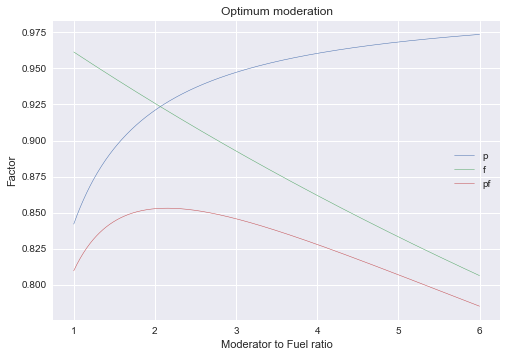

In [359]:
V_m2f_study = np.linspace(1, 6, 500)

p = resonance_escape(enrichment, V_m2f_study, N_mod, N_fuel, led_mod, xs_s_mod, I)
print(p)

f = thermal_utilization(thermal_disadvantage, V_m2f_study, N_mod, N_fuel, xs_a_mod, xs_a_fuel)
print(f)

pf = p*f

fig, ax = plt.subplots()
ax.plot(V_m2f_study, p, linewidth=0.5, label='p')
ax.plot(V_m2f_study, f, linewidth=0.5, label='f')
ax.plot(V_m2f_study, pf, linewidth=0.5, label='pf')
ax.set(xlabel='Moderator to Fuel ratio',ylabel='Factor',
       title='Optimum moderation')
ax.legend()
plt.savefig('pf_geometry_optimization.pdf', bbox_inches='tight')

As we can see, as the moderator to fuel ratio increases, the resonance escape
probability also increases, since the neutron can go through more collisions on
average, avoiding fuel resonances and decreasing absorption.
At the same time, with the increase in moderator to fuel ratio, the thermal
utilization factor decreases, since the chance of the neutron being absorbed in
the moderator increases.

Since both effects have opposite consequences, there must be an optimum point
where the neutron is scattered the most it can but goes on to cause fission in
the fuel without staying unnecessarily long in the moderator. This happens to
be at approximately 2/1 moderator to fuel ratio.

Ironically, no water reactor is designed to have optimum moderation for at
least 2 reasons:
- The impact of moderator feedbacks is minimum, which is not interesting for reactor dynamics
- As soluble boron is added to the moderator, the curve shifts to the left, causing the system to become unsafe due to over-moderation

For these reasons, every LWR is designed to be under-moderated. This causes the
reactor to have negative feedbacks, which is good for reactor control and load
following, while allowing the addition of soluble boron with little impact to safety.